In [1]:
import os
import numpy as np 
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from tensorflow.keras import Sequential, layers, Input

In [2]:
og_df = pd.read_csv('labels.csv')

In [3]:
og_df['label'].value_counts()

label
2    1426
3     930
1     708
Name: count, dtype: int64

In [4]:
df = og_df.copy()

In [5]:
df['label'] = df['label'] - df['label'].min()

In [6]:
# Image directory and resize config
img_dir = 'C:/Users/User/dimaag/png_images'
IMG_SIZE = (224, 224)

In [7]:
# Preload all images and labels into NumPy arrays
images = []
labels = []

for _, row in df.iterrows():
    img_path = os.path.join(img_dir, row['filename'])
    image = load_img(img_path, target_size=IMG_SIZE)
    image = img_to_array(image) / 255.0
    label = row['label']
    images.append(image)
    labels.append(label)

In [8]:
# Convert to NumPy arrays first
images = np.array(images, dtype=np.float32)
labels = np.array(labels, dtype=np.int32)

In [9]:
#Now split the NumPy arrays
X_train, X_val, y_train, y_val = train_test_split(
    images, labels, test_size=0.2, stratify=labels, random_state=42
)

In [10]:
#Convert to TensorFlow tensors
X_train = tf.convert_to_tensor(X_train, dtype=tf.float32)
X_val   = tf.convert_to_tensor(X_val, dtype=tf.float32)
y_train = tf.convert_to_tensor(y_train, dtype=tf.int32)
y_val   = tf.convert_to_tensor(y_val, dtype=tf.int32)

In [11]:
df['label'].value_counts()

label
1    1426
2     930
0     708
Name: count, dtype: int64

In [12]:
custom_cnn_model = Sequential([
    Input(shape=(224, 224, 3)),
    
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(3, activation='softmax')
])

In [13]:
custom_cnn_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',  # Use categorical_crossentropy if labels are one-hot
    metrics=['accuracy']
)

In [14]:
history = custom_cnn_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=32
)

Epoch 1/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 240s 3s/step - accuracy: 0.5755 - loss: 19.1024 - val_accuracy: 0.2316 - val_loss: 164.8392
Epoch 2/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 221s 3s/step - accuracy: 0.7340 - loss: 0.6354 - val_accuracy: 0.2316 - val_loss: 148.2466
Epoch 3/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 218s 3s/step - accuracy: 0.7299 - loss: 0.5877 - val_accuracy: 0.2382 - val_loss: 76.5467
Epoch 4/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 224s 3s/step - accuracy: 0.7115 - loss: 0.6028 - val_accuracy: 0.2316 - val_loss: 47.0977
Epoch 5/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 171s 2s/step - accuracy: 0.7265 - loss: 0.4917 - val_accuracy: 0.2855 - val_loss: 11.9718
Epoch 6/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 162s 2s/step - accuracy: 0.7693 - loss: 0.4620 - val_accuracy: 0.7765 - val_loss: 0.5916
Epoch 7/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 133s 2s/step - accuracy: 0.8078 - loss: 0.4374 - val_accuracy: 0.7700 - val_loss: 0.5425
Epoch 8/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 89s 1s/step - accuracy: 0.8150 - loss: 0.4178 - val_accuracy: 0.7

In [17]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [19]:
# Get predicted probabilities
y_pred_probs = custom_cnn_model.predict(X_val)

# Get predicted class labels
y_pred = np.argmax(y_pred_probs, axis=1)

# Convert y_val to NumPy array if it's a Tensor
y_true = y_val.numpy() if isinstance(y_val, tf.Tensor) else y_val

20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 166ms/step


In [21]:
print("\nClassification Report (Custom Improved CNN):")
class_names = ["Meningioma", "Glioma", "Pituitary"]
print(classification_report(y_true, y_pred, target_names=class_names))


Classification Report (Custom Improved CNN):
              precision    recall  f1-score   support

  Meningioma       0.91      0.82      0.87       142
      Glioma       0.94      0.96      0.95       285
   Pituitary       0.96      0.99      0.98       186

    accuracy                           0.94       613
   macro avg       0.94      0.93      0.93       613
weighted avg       0.94      0.94      0.94       613



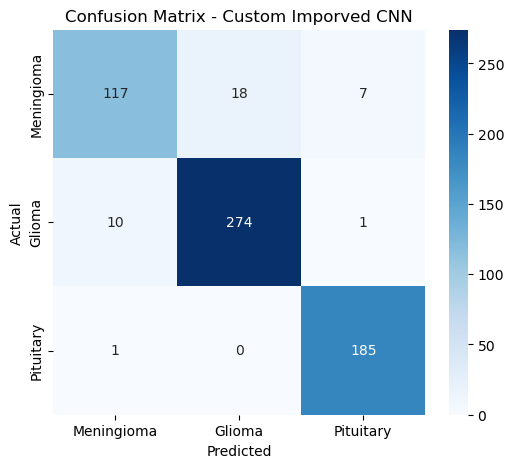

In [23]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Custom Imporved CNN")
plt.show()

In [25]:
loss, accuracy = custom_cnn_model.evaluate(X_val, y_val, verbose=0)
print(f"Custom CNN Accuracy: {accuracy:.4f}")

Custom CNN Accuracy: 0.9396
